In [1]:
import pandas as pd
import numpy as np
import WRIC_preprocessing as wric
import os
import glob
import re
import matplotlib.pyplot as plt
from collections import defaultdict
pd.set_option("display.max_rows", None)

In [10]:
# Path to all cgm files
# folder_path = "D:/Simon_CIRCLE/CGM/"
# skip_list = ["D:/Simon_CIRCLE/CGM/04HH_CGM_v1_treat0.csv"] # different format for some reason
folder_path = "/media/nina/SUNSHINE/Simon_CIRCLE/CGM/"
skip_list = ["/media/nina/SUNSHINE/Simon_CIRCLE/CGM/04HH_CGM_v1_treat0.csv"] 

meta_data = []
df_dictionary = {}

for filepath in glob.glob(folder_path + "*.csv"):
    print(filepath)
    if filepath not in skip_list:
        # get visit and treatment variable from file-name
        match = re.search(r'_v(\d+)_treat(\d+)\.csv$', filepath)
        if match:
            visit = int(match.group(1))
            treat = int(match.group(2))

        # read in csv file
        df = pd.read_csv(filepath, index_col="Index")

        # save meta data
        id = df.loc[1, "Patient Info"]
        dob = df.loc[df['Event Type'] == 'DateOfBirth', 'Patient Info'].values[0]
        meta_data.append({"ID" : id, "DateOfBirth" : dob, "visit" : visit, "treat" : treat})

        # drop unnecessary rows and columns and save in dict
        df = df[df['Timestamp (YYYY-MM-DDThh:mm:ss)'].notna()]
        df.reset_index(inplace=True)
        df = df.drop(columns=["Index","Event Type","Event Subtype","Patient Info","Device Info","Source Device ID", "Insulin Value (u)","Carb Value (grams)","Duration (hh:mm:ss)","Glucose Rate of Change (mmol/L/min)","Transmitter Time (Long Integer)","Transmitter ID"])
        df.rename(columns={'Timestamp (YYYY-MM-DDThh:mm:ss)' : "datetime", "Glucose Value (mmol/L)": "glucose"}, inplace=True)
        
        # Cut until 6pm on the first day for everyone (same timeline, but also according to Helene the first hours do not give realistic data anyways)
        df["datetime"] = pd.to_datetime(df["datetime"])
        first_day = df['datetime'].iloc[0].date()
        cutoff_time = pd.Timestamp(f'{first_day} 18:00:00')
        df = df[df['datetime'] >= cutoff_time]
        
        # Replace "low" with None (for visualization) - make sure this is know!
        df["glucose"] = np.where(df["glucose"] == "Low", None, df["glucose"]).astype(float)
        df = wric.add_relative_time(df)
        df_dictionary[f'{id}_t{str(treat)}'] = df
        
 
# convert meta-data to df   
df_meta = pd.DataFrame(meta_data)

/media/nina/SUNSHINE/Simon_CIRCLE/CGM/01JJ_CGM_v1_treat0.csv
/media/nina/SUNSHINE/Simon_CIRCLE/CGM/01JJ_CGM_v2_treat1.csv
/media/nina/SUNSHINE/Simon_CIRCLE/CGM/02LK_CGM_v1_treat1.csv
/media/nina/SUNSHINE/Simon_CIRCLE/CGM/02LK_CGM_v2_treat0.csv
/media/nina/SUNSHINE/Simon_CIRCLE/CGM/03HA_CGM_v1_treat1.csv
/media/nina/SUNSHINE/Simon_CIRCLE/CGM/03HA_CGM_v2_treat0.csv
/media/nina/SUNSHINE/Simon_CIRCLE/CGM/04HH_CGM_v2_treat1.csv
/media/nina/SUNSHINE/Simon_CIRCLE/CGM/05PM_CGM_v1_treat0.csv
/media/nina/SUNSHINE/Simon_CIRCLE/CGM/05PM_CGM_v2_treat1.csv
/media/nina/SUNSHINE/Simon_CIRCLE/CGM/06ML_CGM_v1_treat0.csv
/media/nina/SUNSHINE/Simon_CIRCLE/CGM/06ML_CGM_v2_treat1.csv
/media/nina/SUNSHINE/Simon_CIRCLE/CGM/07AB_CGM_v1_treat1.csv
/media/nina/SUNSHINE/Simon_CIRCLE/CGM/07AB_CGM_v2_treat0.csv
/media/nina/SUNSHINE/Simon_CIRCLE/CGM/08MG_CGM_v1_treat1.csv
/media/nina/SUNSHINE/Simon_CIRCLE/CGM/08MG_CGM_v2_treat0.csv
/media/nina/SUNSHINE/Simon_CIRCLE/CGM/09NQ_CGM_v1_treat1.csv
/media/nina/SUNSHINE/Sim

01JJ_t0
01JJ_t1
02LK_t1
02LK_t0
03HA_t1
03HA_t0
04HH_t1
05PM_t0
05PM_t1
06ML_t0
06ML_t1
07AB_t1
07AB_t0
08MG_t1
08MG_t0
09NQ_t1
09NQ_t0
10JK_t0
10JK_t1


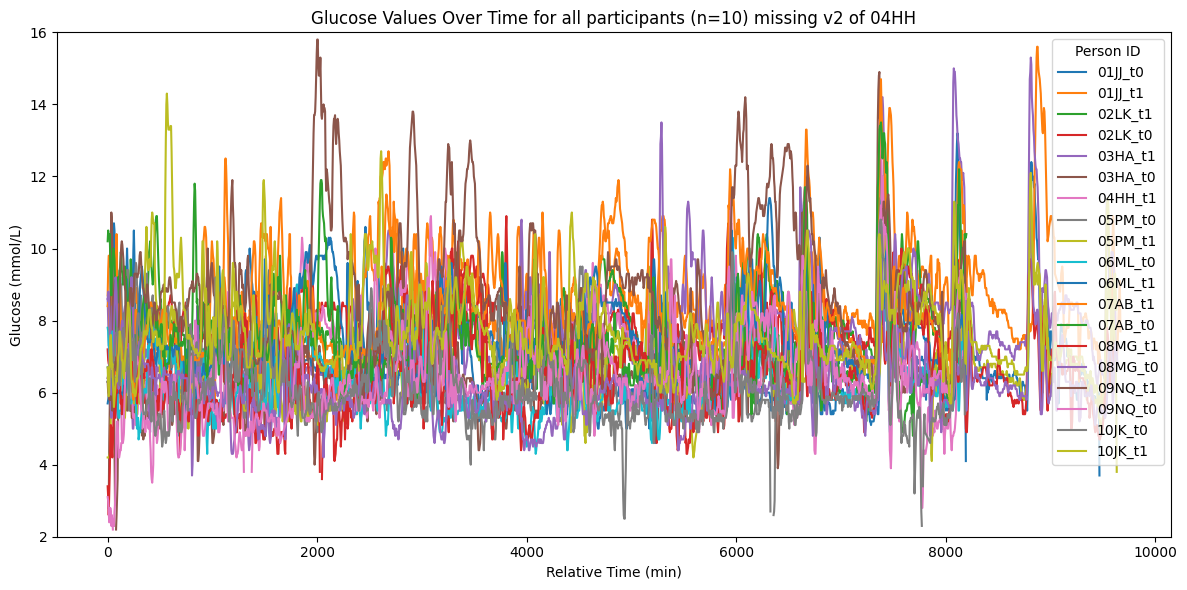

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
for person_id, df in df_dictionary.items():
    print(person_id)
    ax.plot(df['relative_time[min]'], df['glucose'], label=person_id)
        
#plt.xticks(rotation=45)
ax.set_xlabel("Relative Time (min)")
ax.set_ylabel("Glucose (mmol/L)")
ax.set_ylim(2, 16)
ax.set_title("Glucose Values Over Time for all participants (n=10) missing v2 of 04HH")

# Add a legend to distinguish each person
ax.legend(title="Person ID")

plt.tight_layout()
plt.savefig("/media/nina/SUNSHINE/Simon_CIRCLE/Visualizations/glucose_all.png")
plt.show()

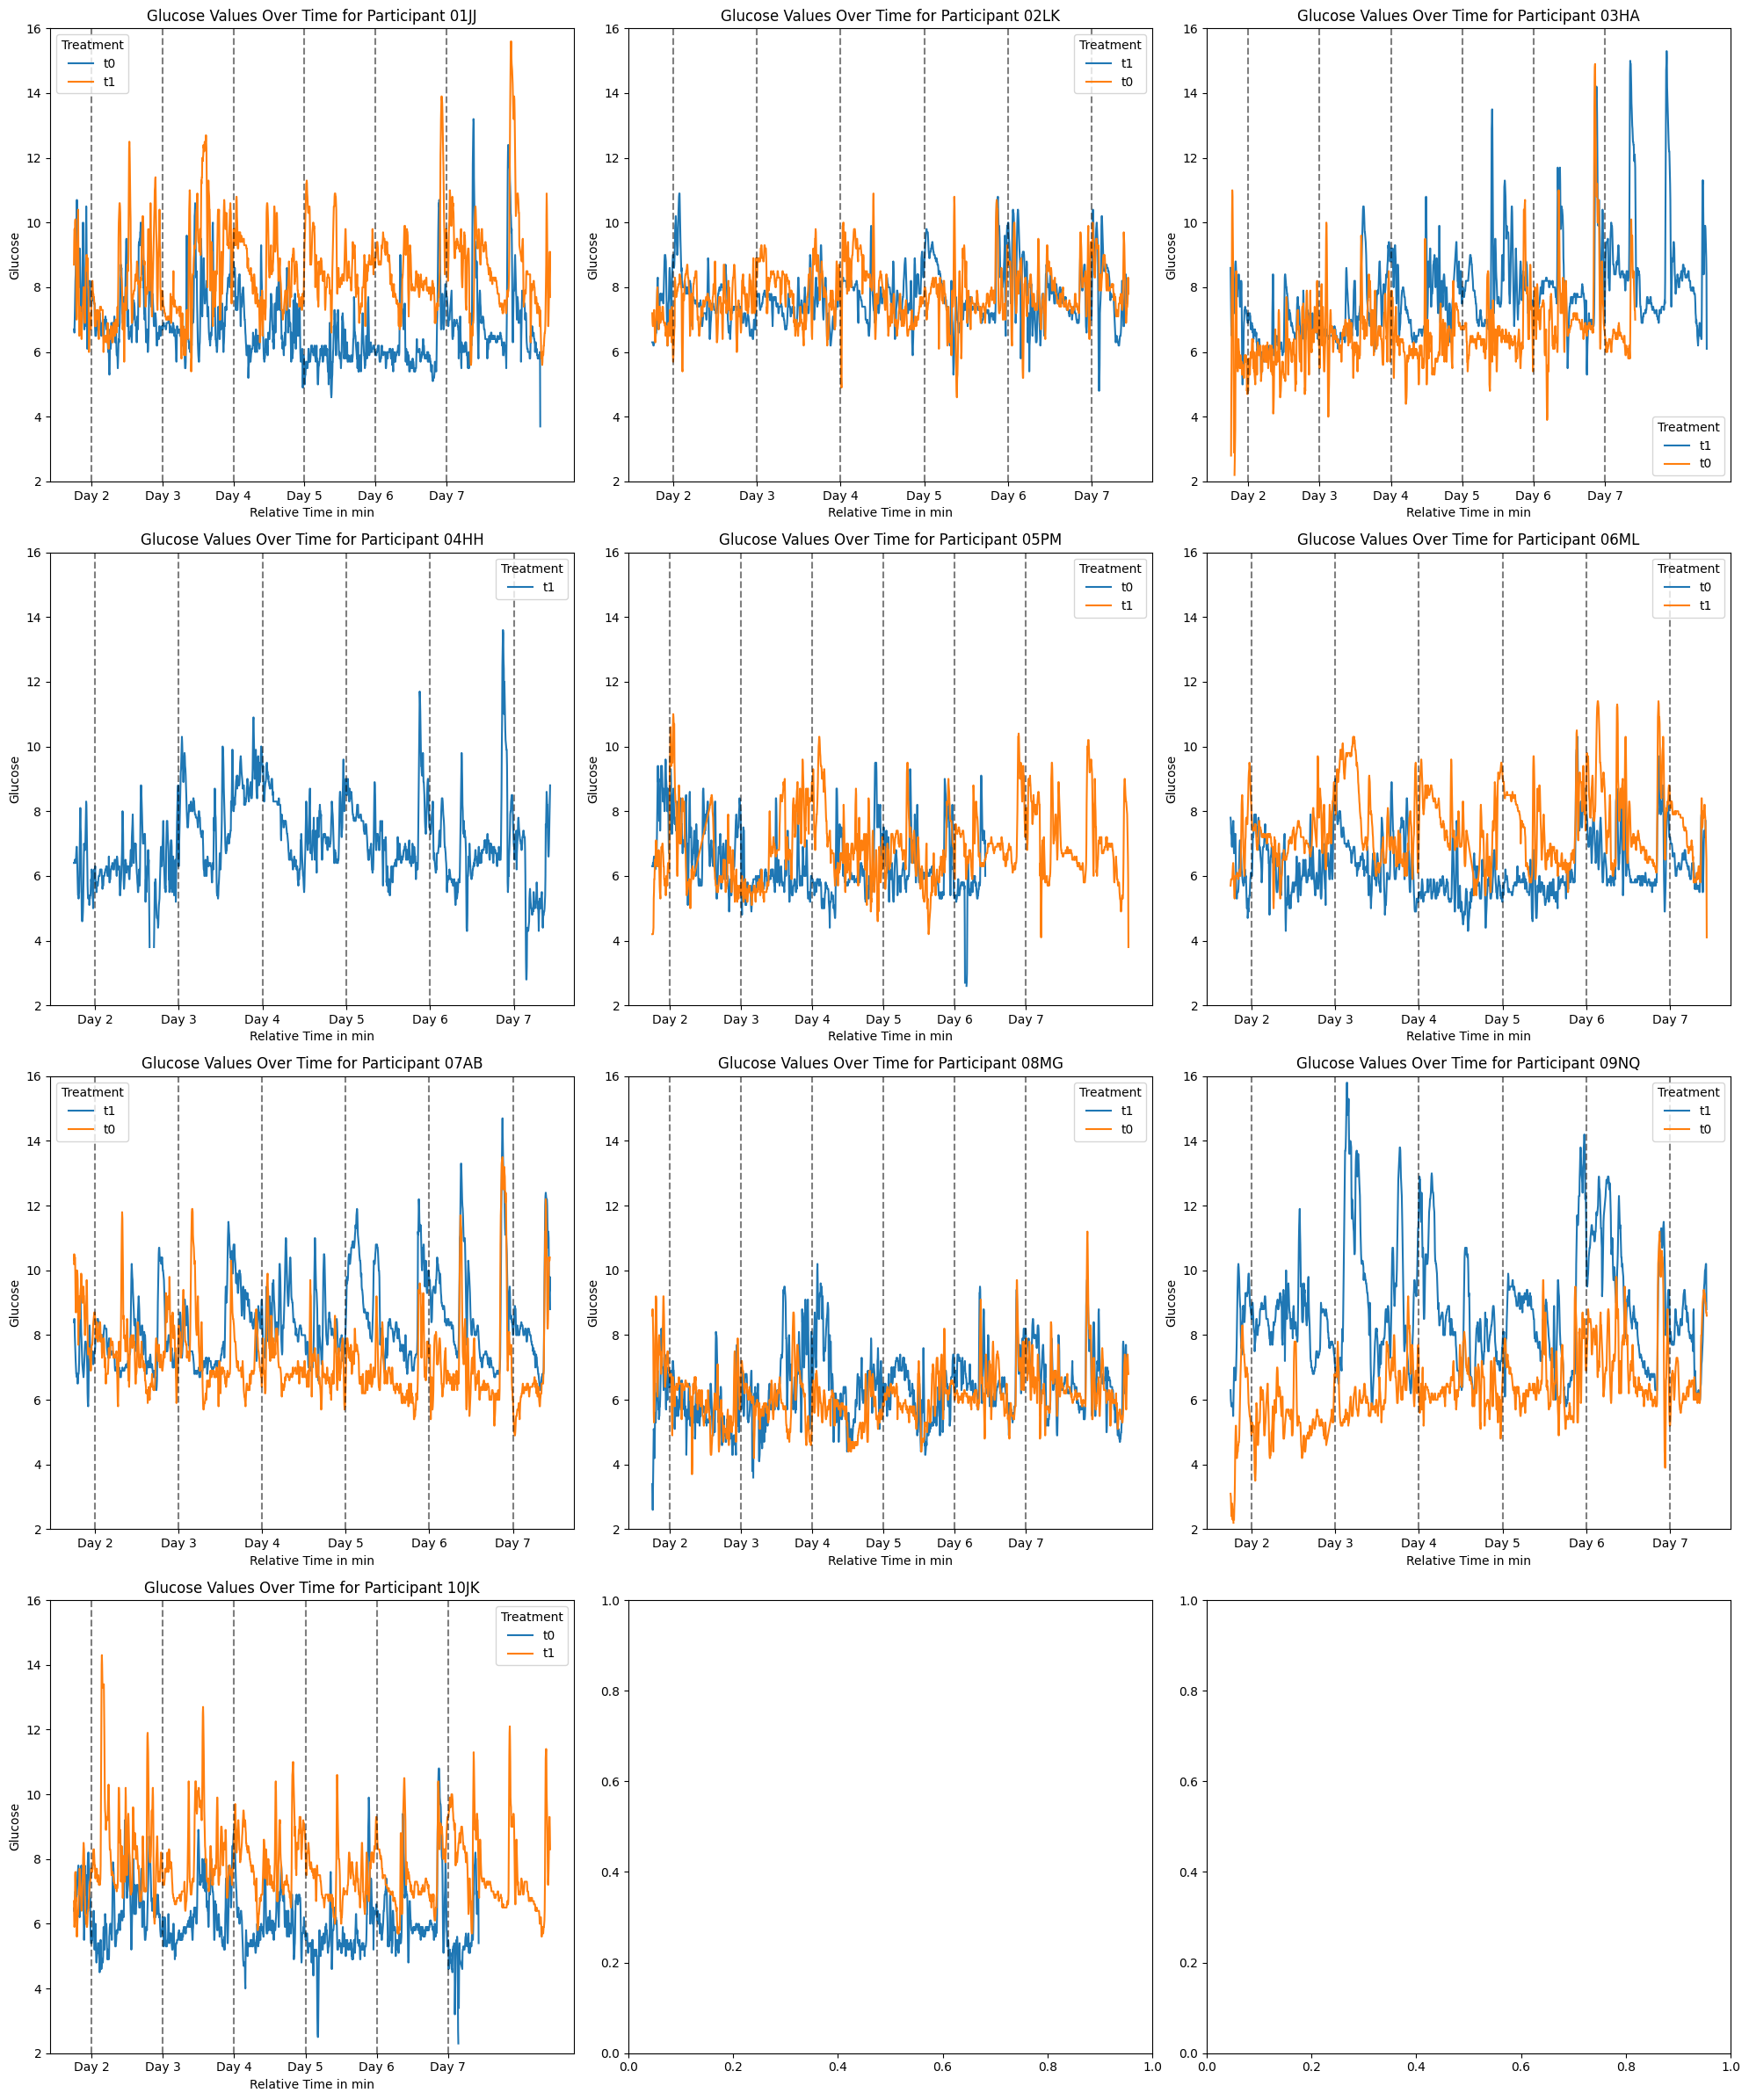

In [18]:
groups = defaultdict(list)

# Group identifiers based on the first four characters
for person_id in df_dictionary.keys():
    group_key = person_id[:4]  # Get the first four characters
    groups[group_key].append(person_id)
    
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 6 * 4))

# Flatten the axs array if needed (for easy indexing)
axs = axs.flatten()

# Create subplots for each group
for ax, (group_id, person_ids) in zip(axs, groups.items()):
    # Plot each person in the group
    for person_id in person_ids:
        df = df_dictionary[person_id]  # Access the DataFrame for the person
        ax.plot(df['relative_time[min]'], df['glucose'], label=person_id.split('_')[1])  # Use v1 or v2 as label

    ax.set_xlabel("Relative Time in min")
    ax.set_ylabel("Glucose")
    ax.set_ylim(2, 16)
    ax.set_title(f"Glucose Values Over Time for Participant {group_id}")
    
    x = 1440 # minutes in a day
    y = 360 # first 6 hours
    tick_positions = [y + i * x for i in range(6)]  
    tick_labels = [f"Day {day}" for day in ["2", '3', '4', '5', '6', '7']]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    for tick in tick_positions:
        ax.axvline(x=tick, color='black', linestyle='--', alpha=0.5)  # Dashed line at each tick position


    # Add a legend to distinguish each version
    ax.legend(title="Treatment")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig("/media/nina/SUNSHINE/Simon_CIRCLE/Visualizations/glucose_values_by_person.png")
plt.show()

In [ ]:
# TODO: Make the relative time start at the same time of day for each person - or map from the back so longer would be fine? And then mark days and WRIC 
# Check skipping time stamps - maybe scatter plot not line?

# Adding CGM, Temperature and EE in one plot

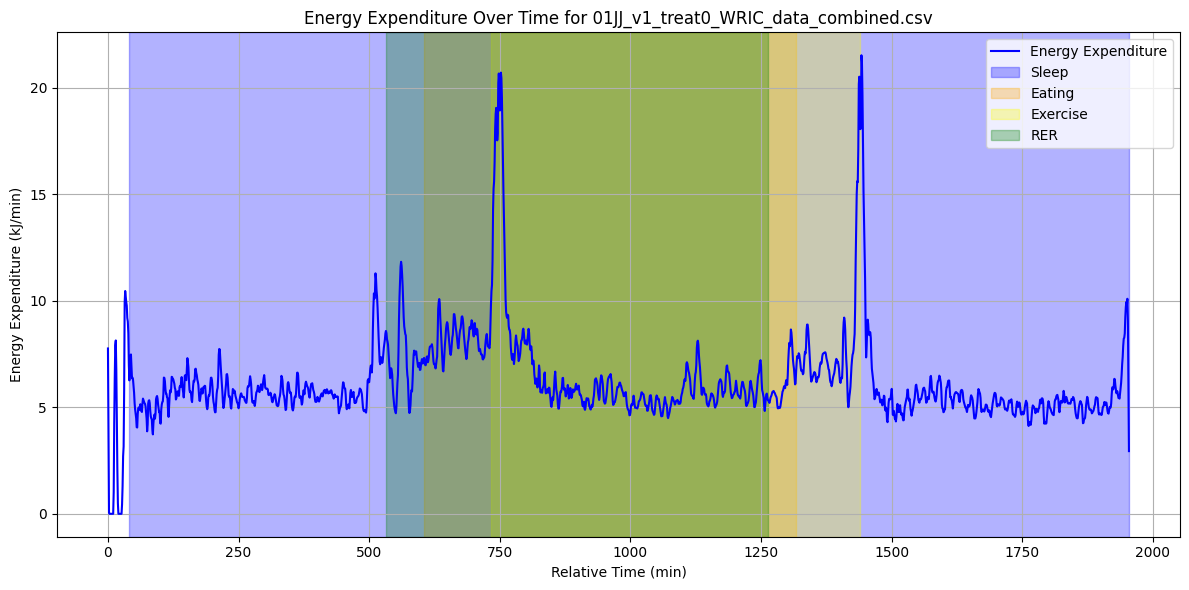

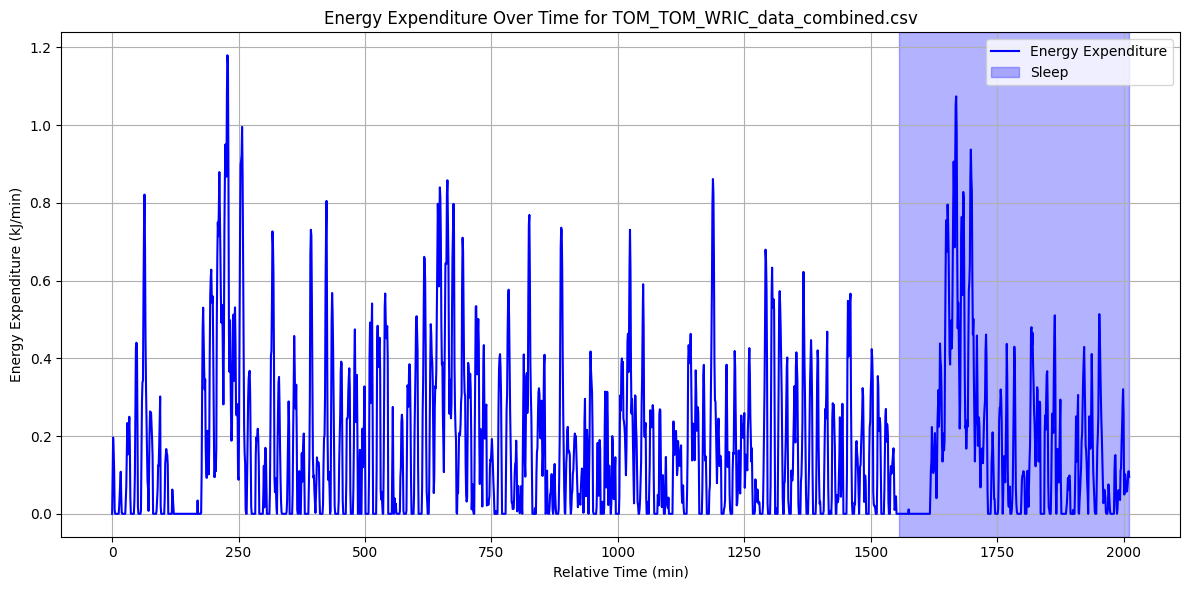

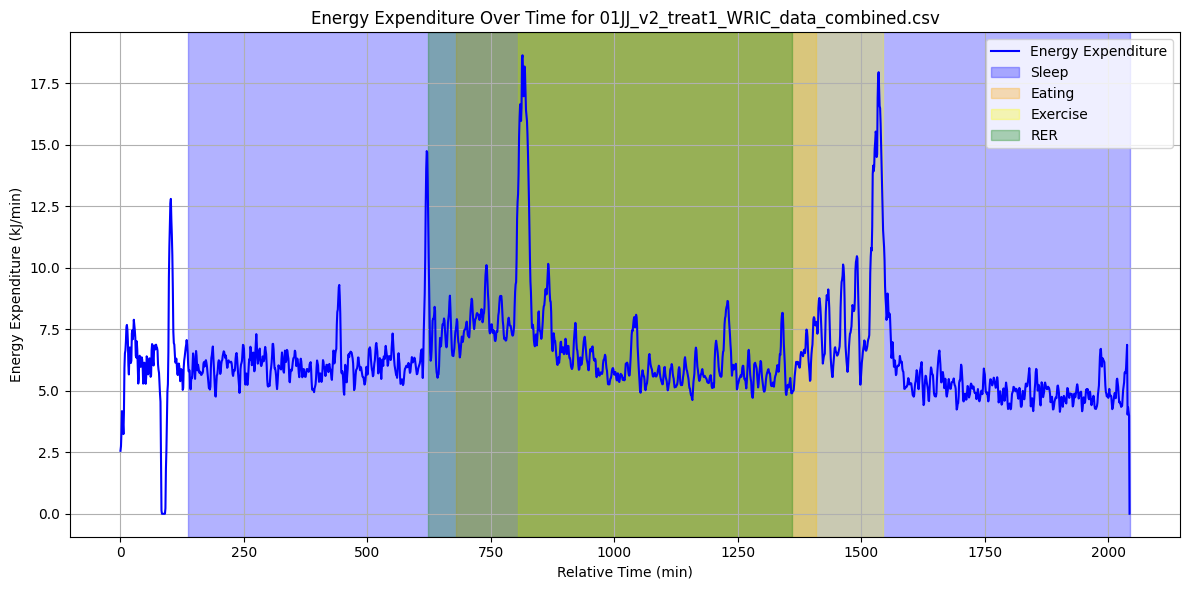

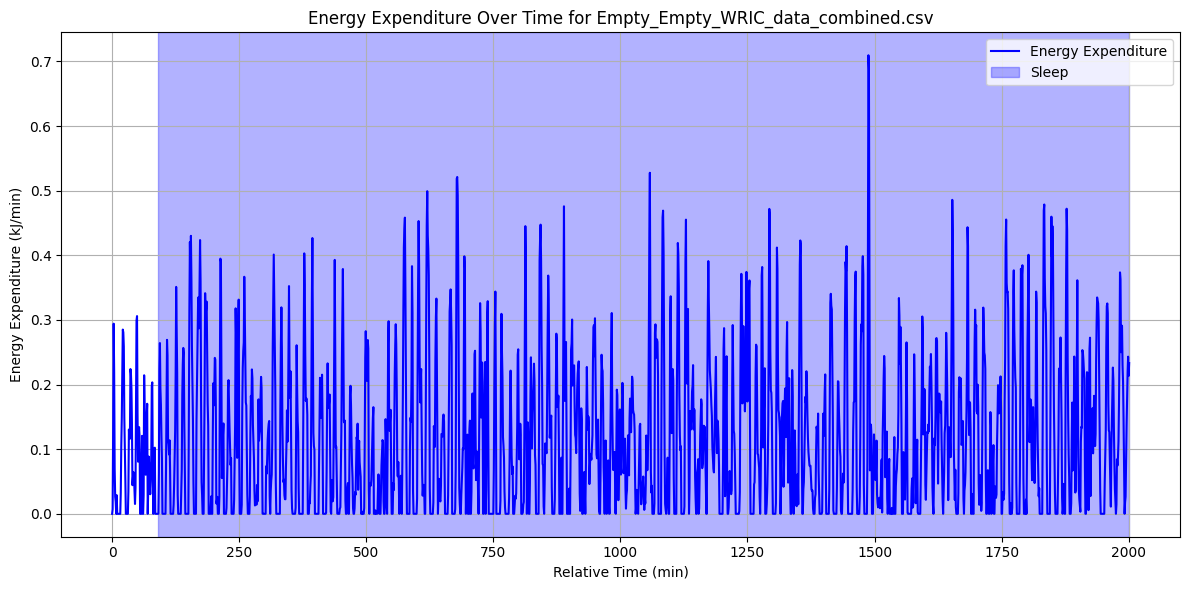

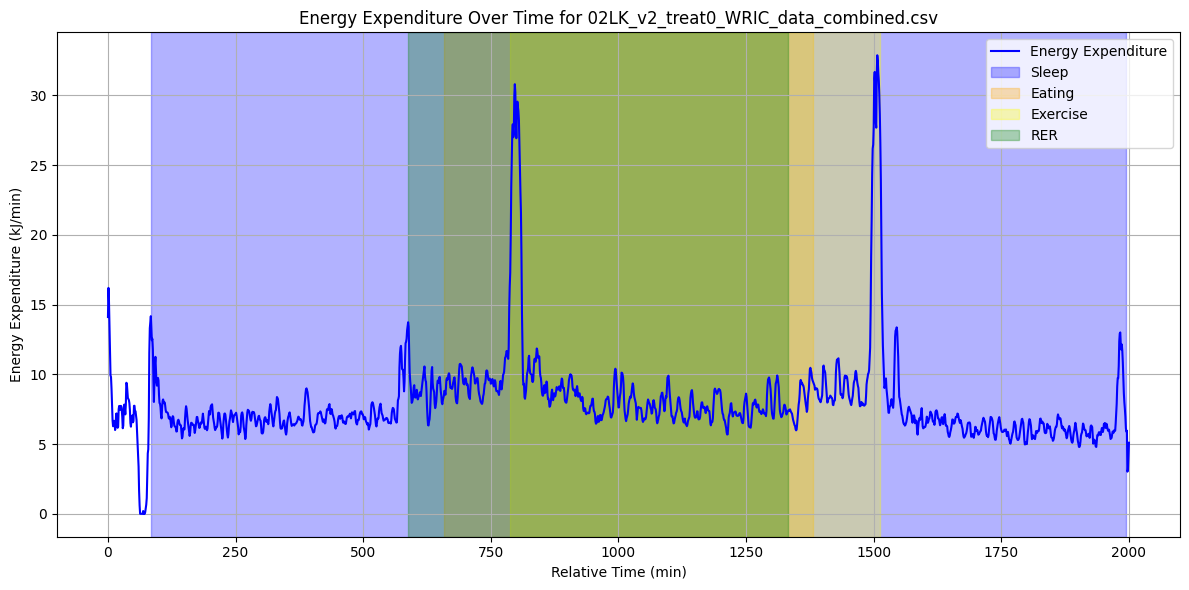

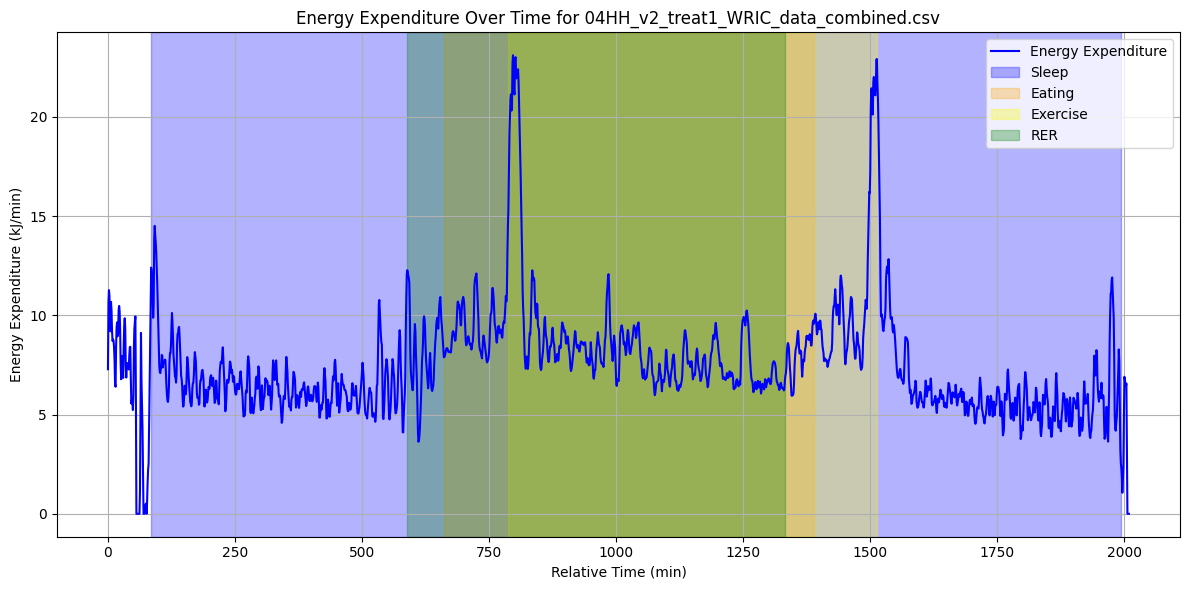

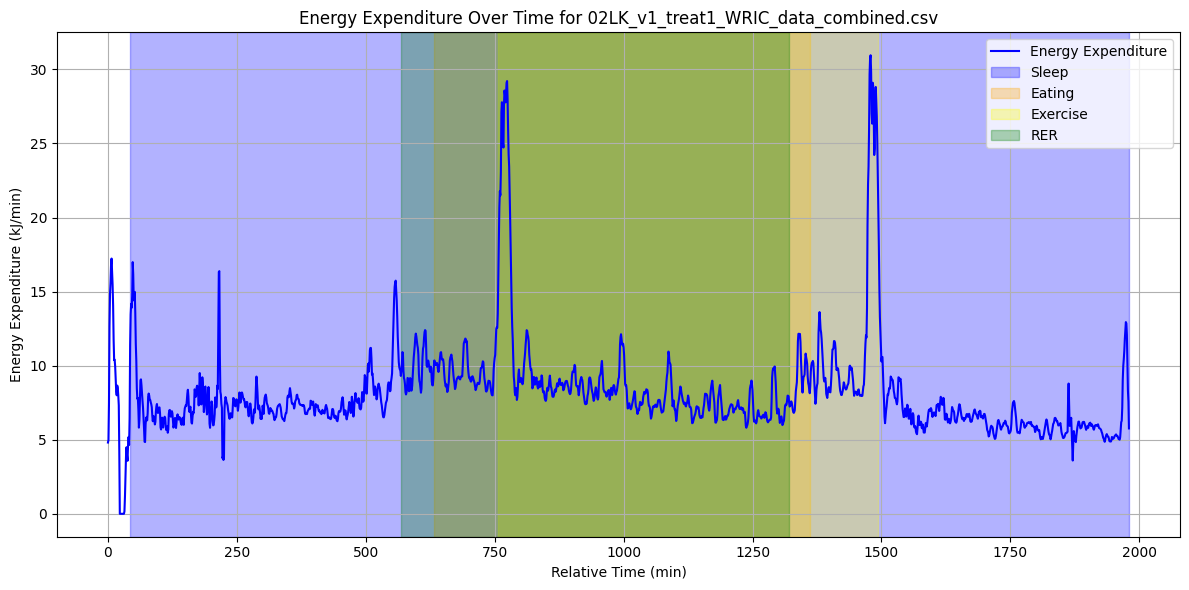

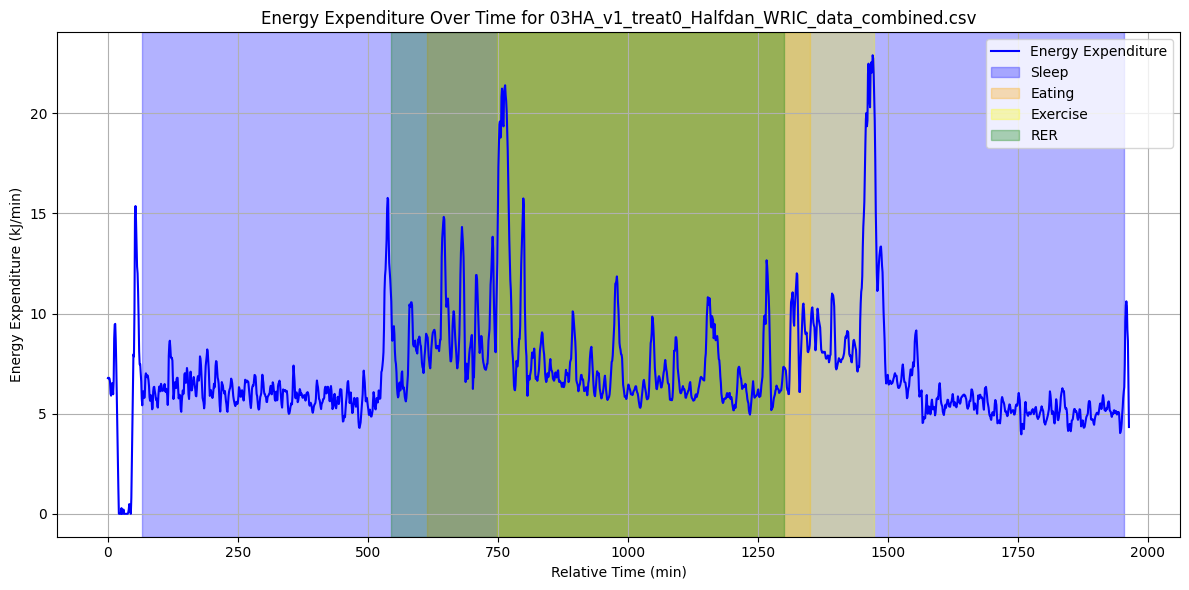

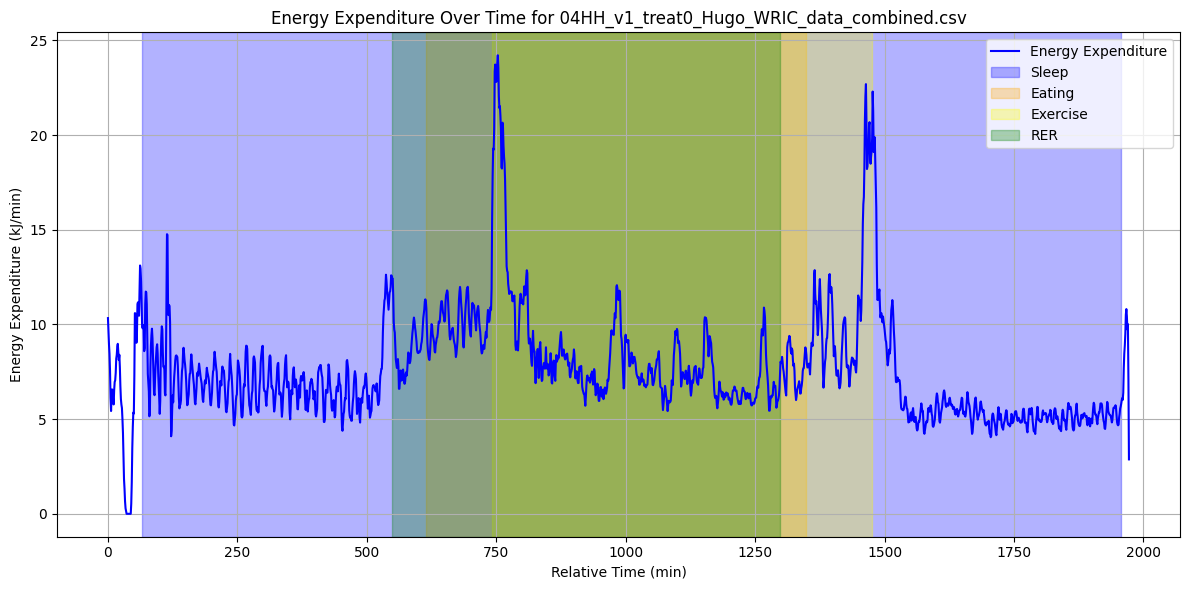

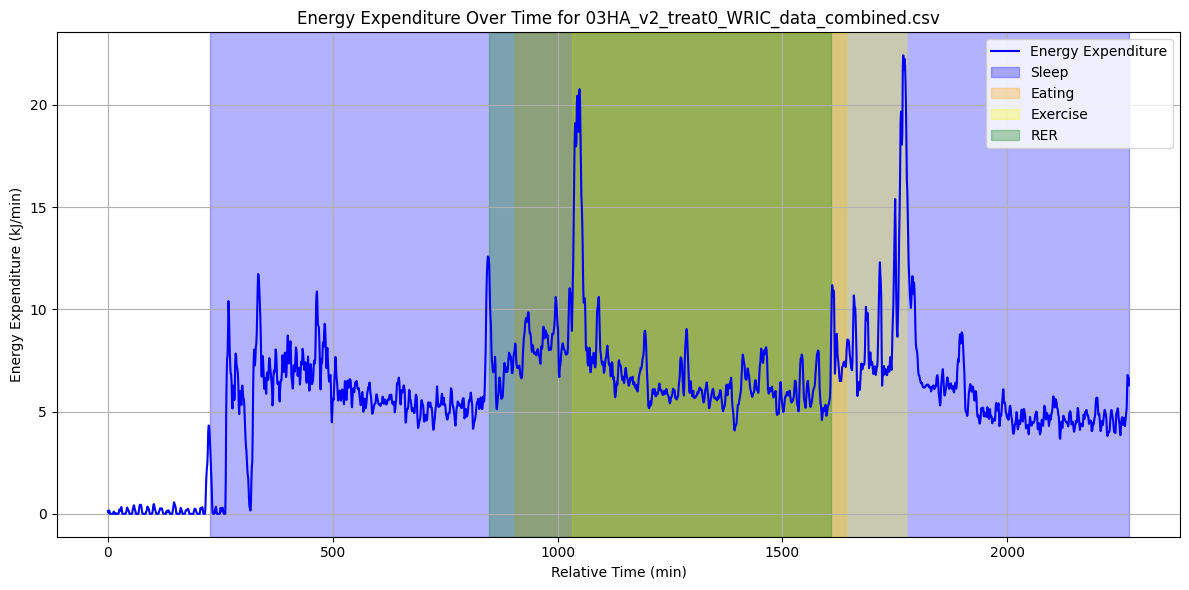

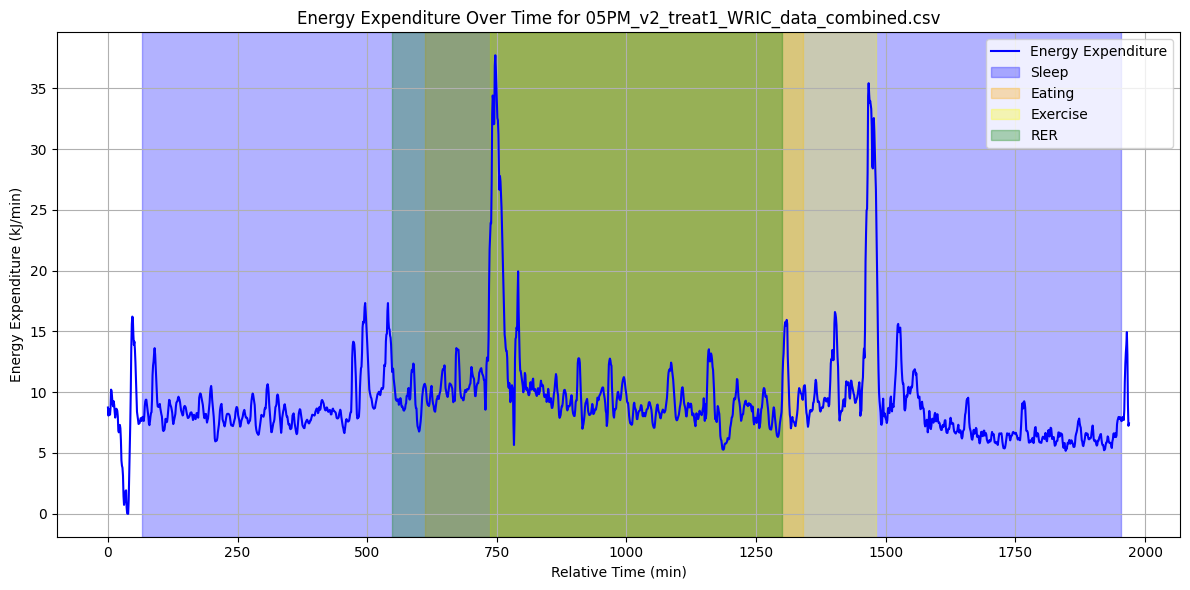

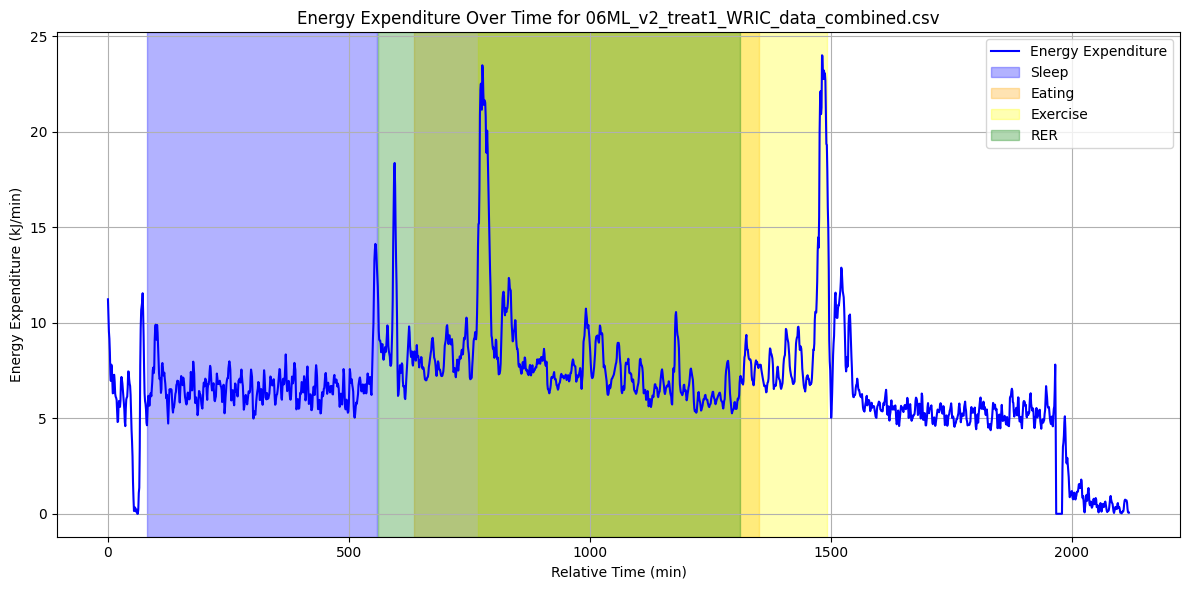

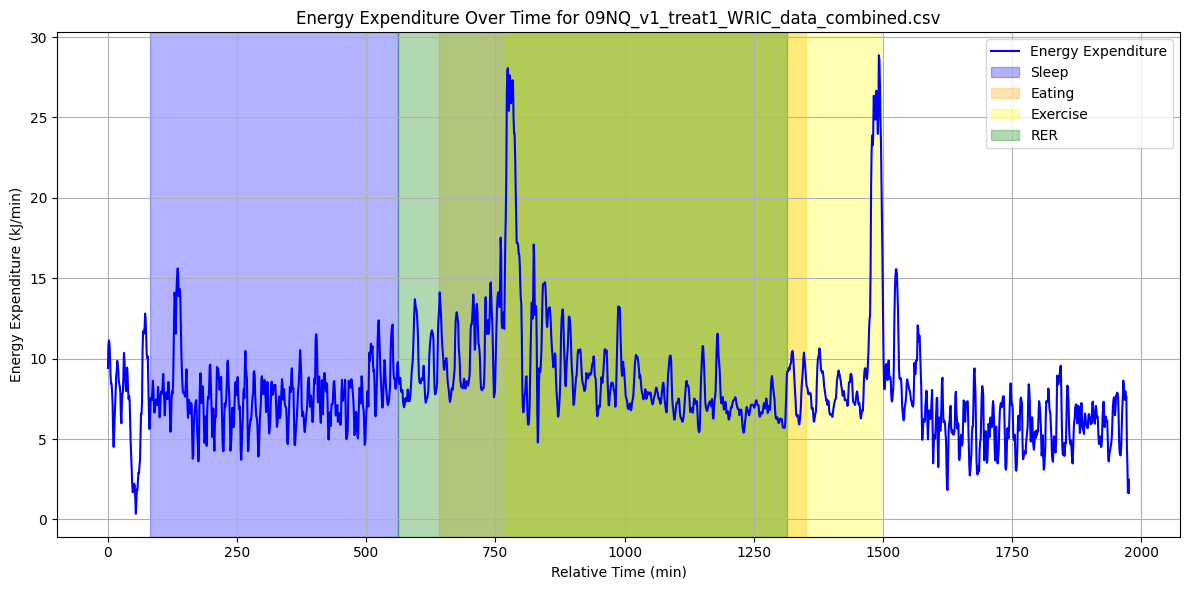

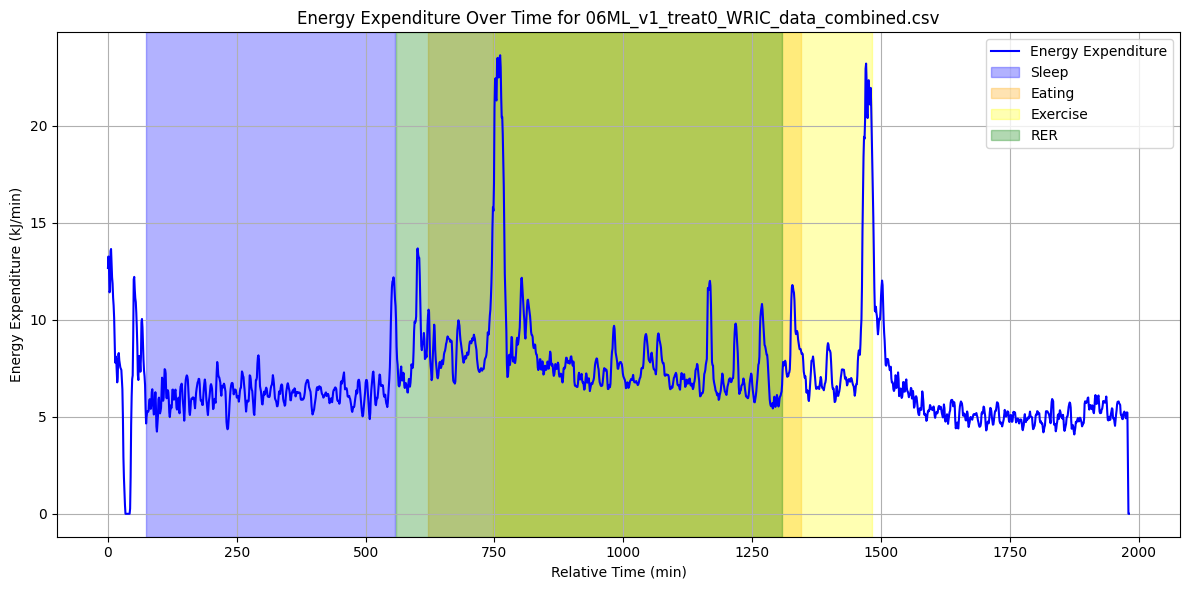

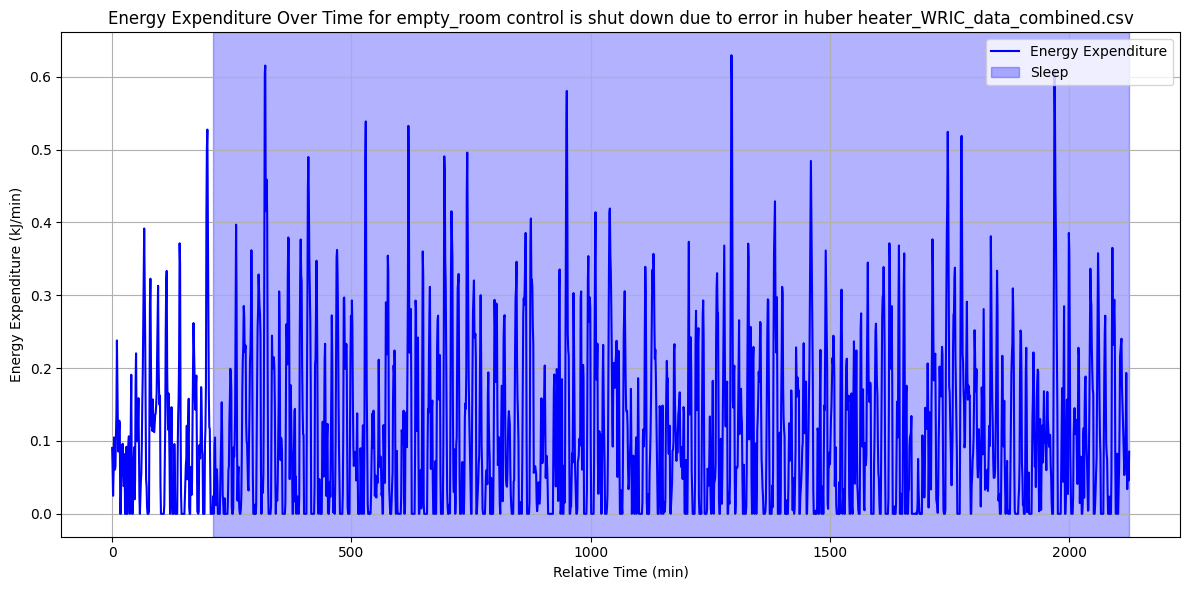

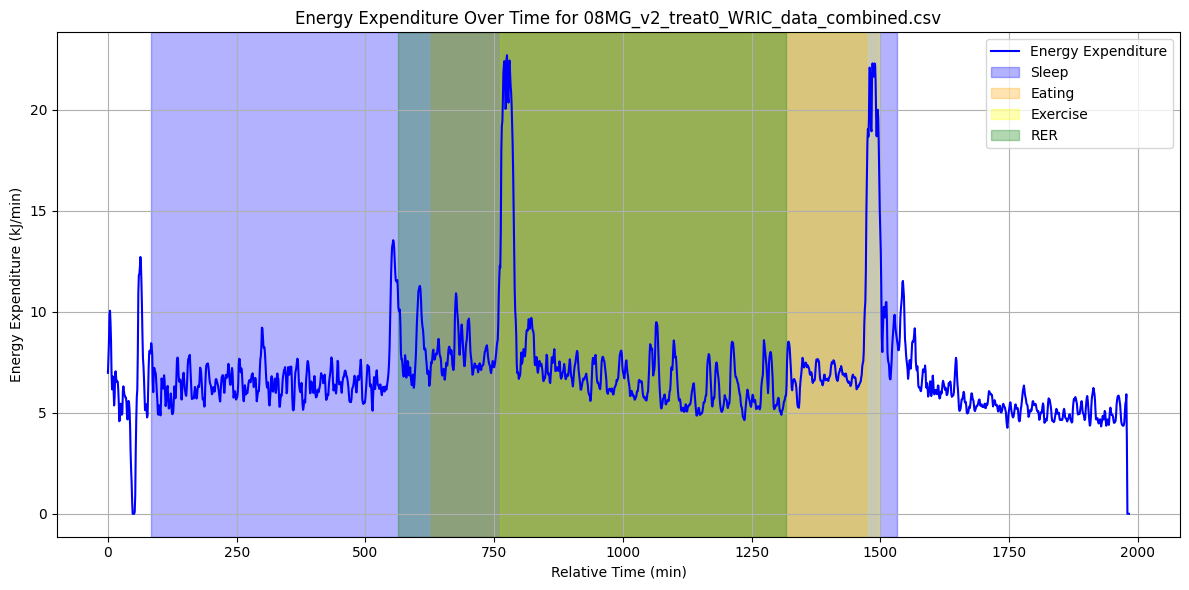

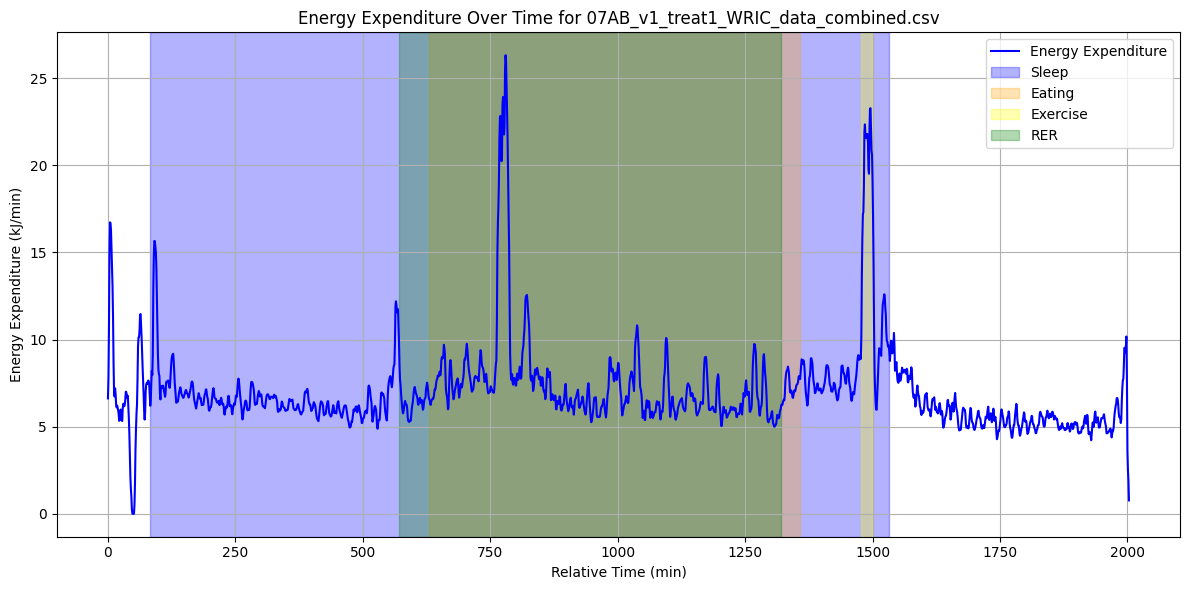

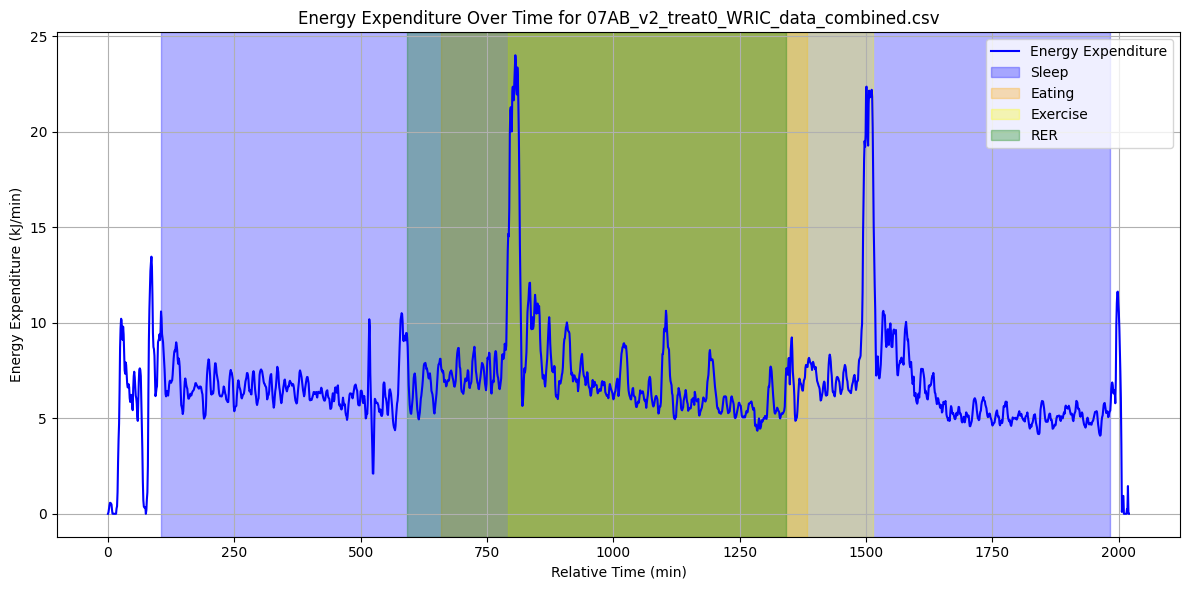

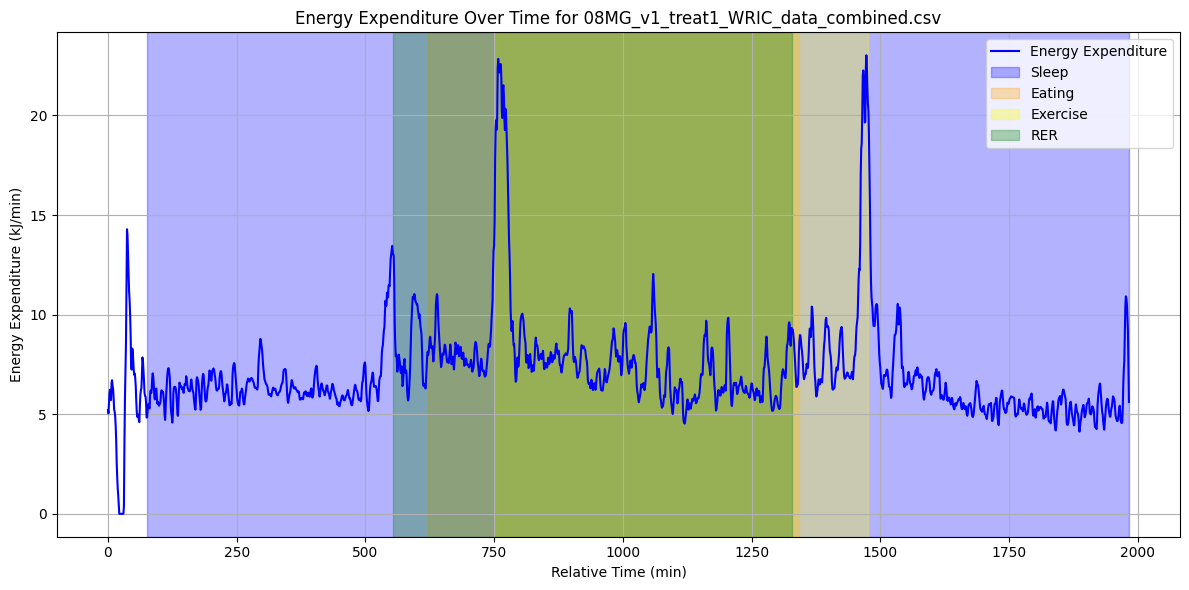

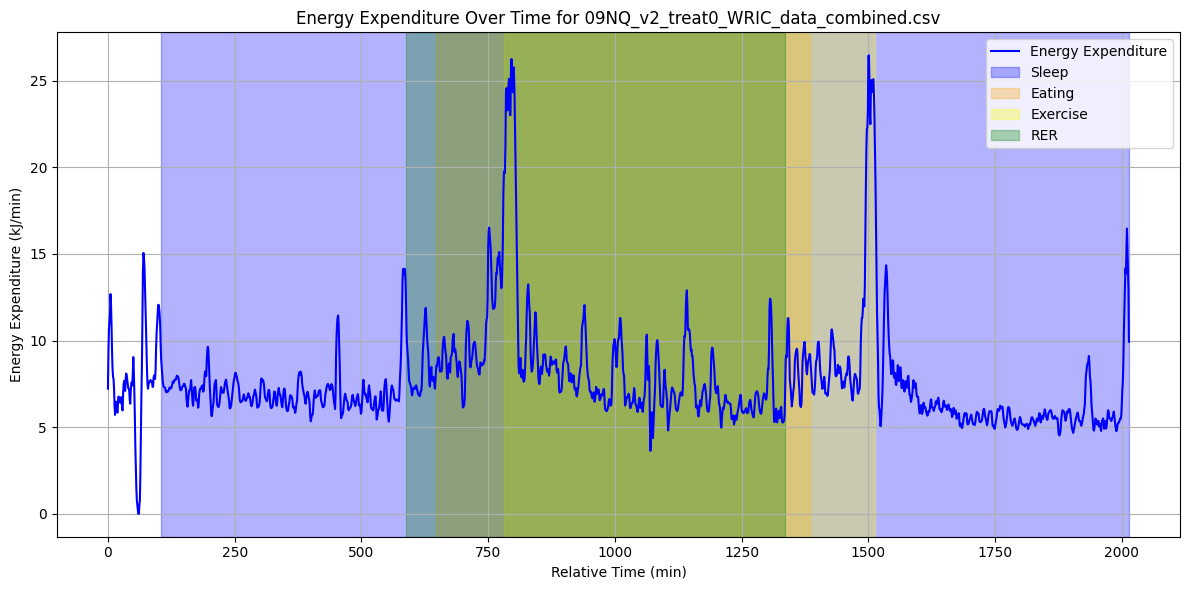

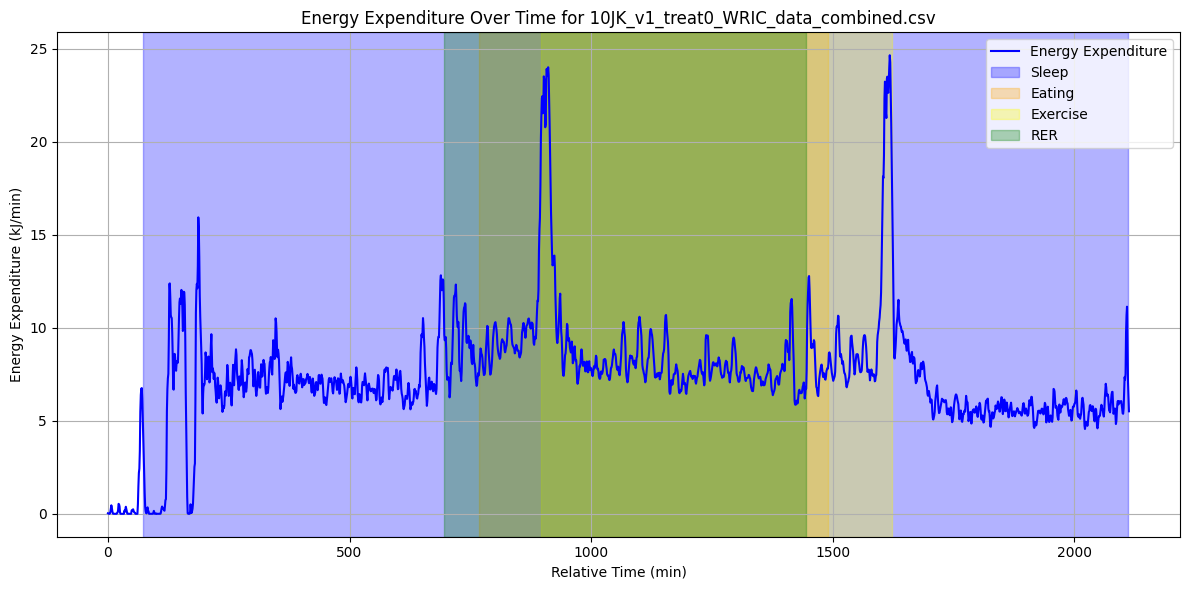

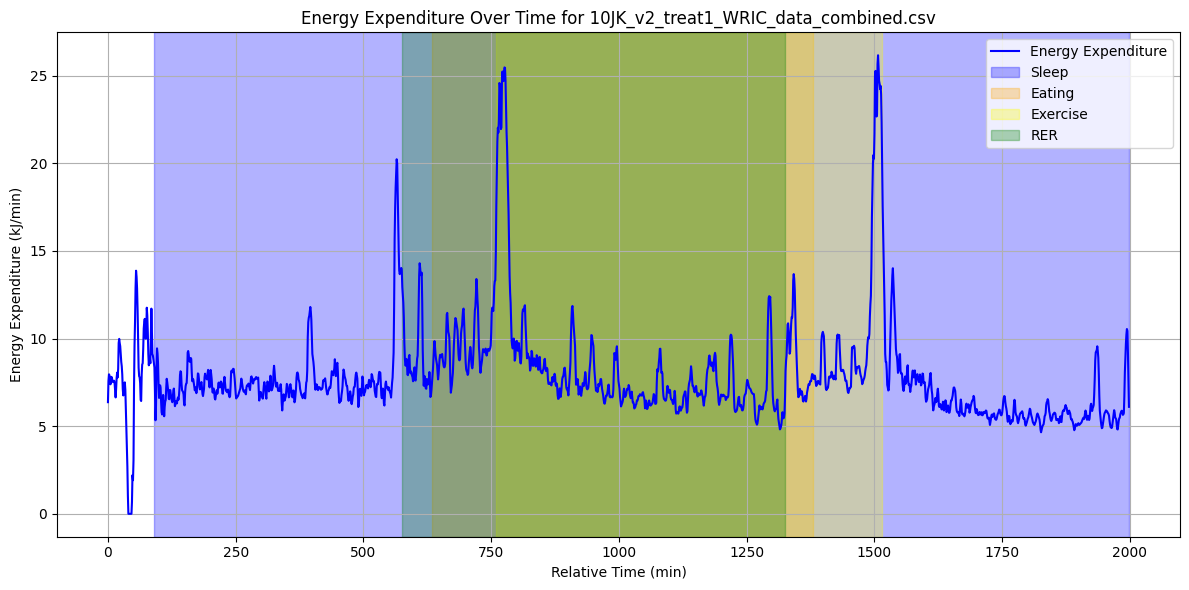

In [17]:
# Path to the folder containing the files
folder_path = "/media/nina/SUNSHINE/Simon_CIRCLE/WRIC/processed"
# Step 1: Get all files ending with "_combined.csv"
csv_files = [file for file in os.listdir(folder_path) if file.endswith("_combined.csv")]

protocol_colors_labels = {
    0: {"color": "white", "label": "Normal"},
    1: {"color": "blue", "label": "Sleep"},
    2: {"color": "orange", "label": "Eating"},
    3: {"color": "yellow", "label": "Exercise"},
    4: {"color": "green", "label": "RER"},
}

# Step 2: Read files into DataFrames
dataframes = []  # List to store all DataFrames

for file in csv_files:
    # Read the file
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    dataframes.append(df)

    # Step 3: Plot energy expenditure ("ee") over time
    plt.figure(figsize=(12, 6))
    plt.plot(df["relative_time[min]"], df["Energy Expenditure (kJ/min)"], label="Energy Expenditure", color="blue")

    # Highlight background based on "protocol" values
    for protocol, group in df.groupby("protocol"):
        protocol_info = protocol_colors_labels.get(protocol, None)
        if protocol_info and protocol != 0:  # Skip coloring for protocol 0
            start_time = group["relative_time[min]"].min()
            end_time = group["relative_time[min]"].max()
            plt.axvspan(start_time, end_time, color=protocol_info["color"], alpha=0.3, label=protocol_info["label"])

    # Add labels, legend, and title
    plt.xlabel("Relative Time (min)")
    plt.ylabel("Energy Expenditure (kJ/min)")
    plt.title(f"Energy Expenditure Over Time for {file}")
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    plt.grid(True)
    plt.tight_layout()

    # Show and save
    save_path = f"/media/nina/SUNSHINE/Simon_CIRCLE/Visualizations/EE_{file.replace('.csv', '.png')}"
    plt.savefig(save_path)
    plt.show()

In [15]:
print(df_dictionary.keys())
print(len(dataframes))

dict_keys(['01JJ_t0', '01JJ_t1', '02LK_t1', '02LK_t0', '03HA_t1', '03HA_t0', '04HH_t1', '05PM_t0', '05PM_t1', '06ML_t0', '06ML_t1', '07AB_t1', '07AB_t0', '08MG_t1', '08MG_t0', '09NQ_t1', '09NQ_t0', '10JK_t0', '10JK_t1'])
22


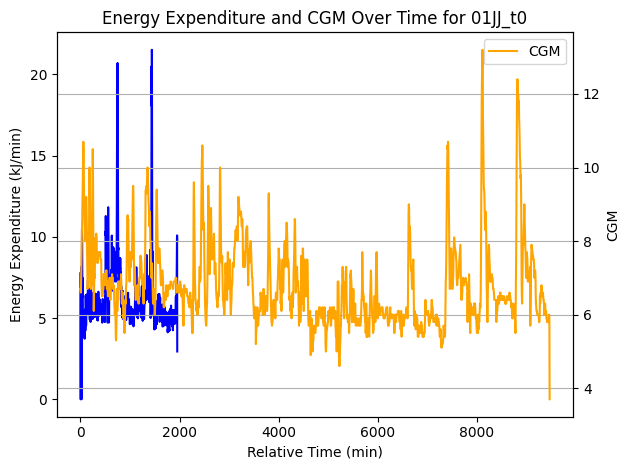

In [28]:
# examplary for 01JJ

file_path = "/media/nina/SUNSHINE/Simon_CIRCLE/WRIC/processed/01JJ_v1_treat0_WRIC_data_combined.csv"
df = pd.read_csv(file_path)

# Step 3: Plot energy expenditure ("ee") over time
fig, ax1 = plt.subplots()
ax1.plot(df["relative_time[min]"], df["Energy Expenditure (kJ/min)"], label="Energy Expenditure", color="blue")
ax2 = ax1.twinx()
cgm = df_dictionary["01JJ_t0"]
ax2.plot(cgm['relative_time[min]'], cgm['glucose'], label = "CGM", color="orange")
ax2.set_ylabel("CGM")

# Add labels, legend, and title
ax1.set_xlabel("Relative Time (min)")
ax1.set_ylabel("Energy Expenditure (kJ/min)")
plt.title(f"Energy Expenditure and CGM Over Time for 01JJ_t0")
plt.legend()

plt.grid(True)
plt.tight_layout()

# Show and save
save_path = f"/media/nina/SUNSHINE/Simon_CIRCLE/Visualizations/EE_CGM_01JJ_treat0.png"
plt.savefig(save_path)
plt.show()

# TODO: Align time